In [1]:
import sys
import numpy as np
import import_ipynb
import pandas as pd
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_processing import matrices_assembly as ma
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 3:
# 3-noded Linear Triangular Elements, $P_1$

In [2]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'BGT', 'value': None, 'name': 'truncated_domain'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# ABC Formulation

Processing domain with R1 = 0.75λ
Model circular_pec (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 1506 nodes in total
Info     : 2755 2-D elements in total


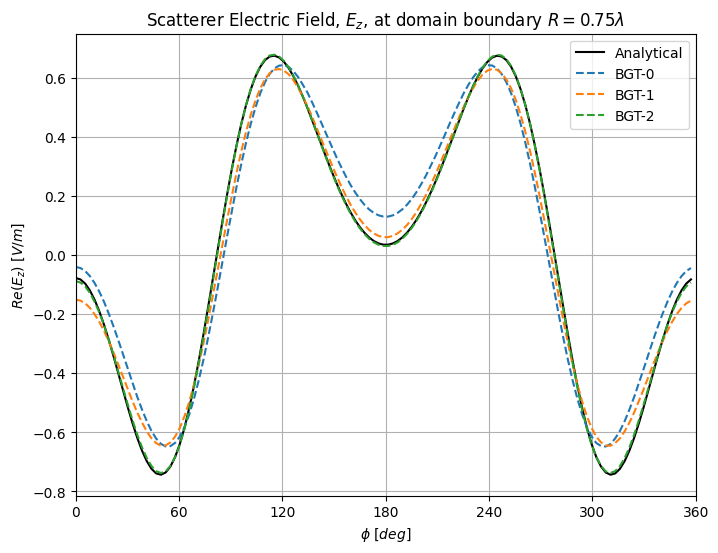

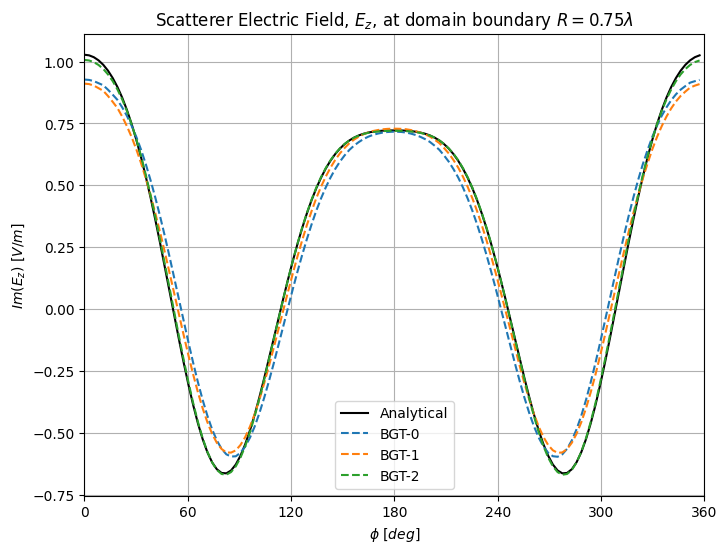

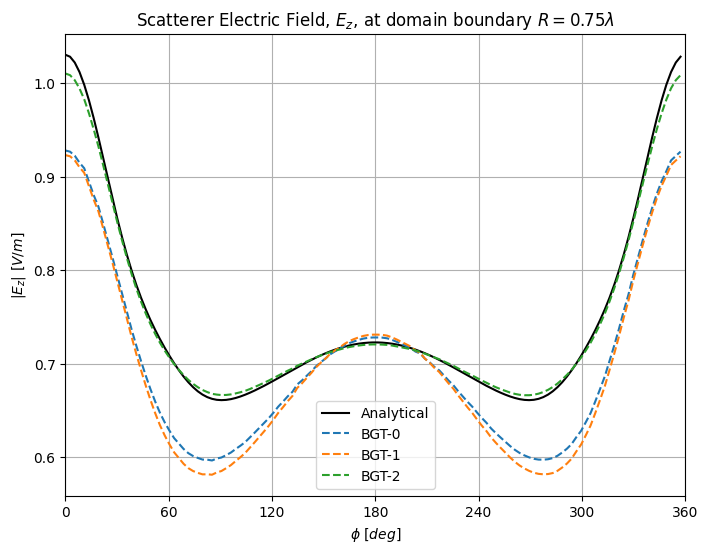

Processing domain with R2 = λ
Model circular_pec (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 2414 nodes in total
Info     : 4576 2-D elements in total


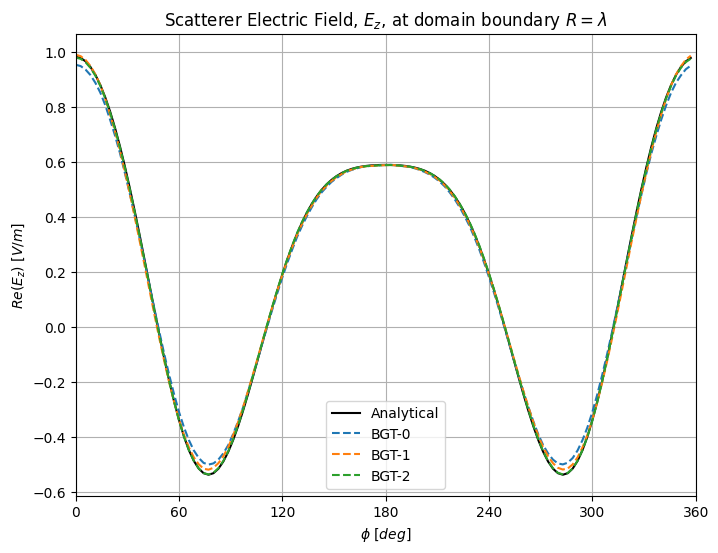

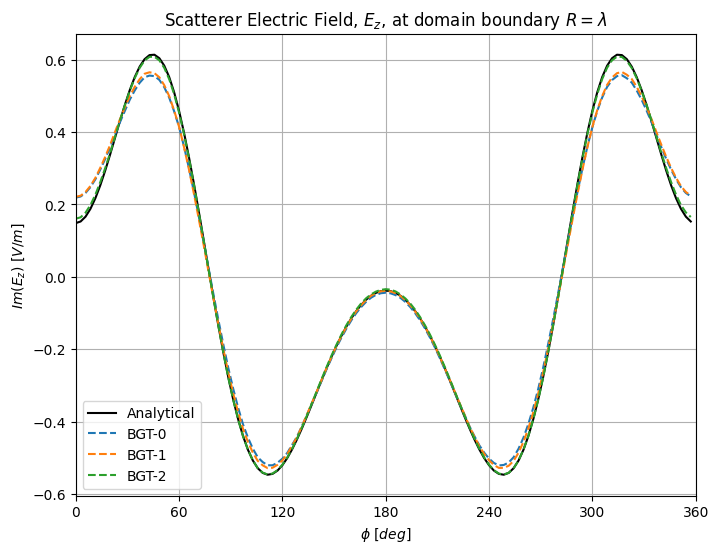

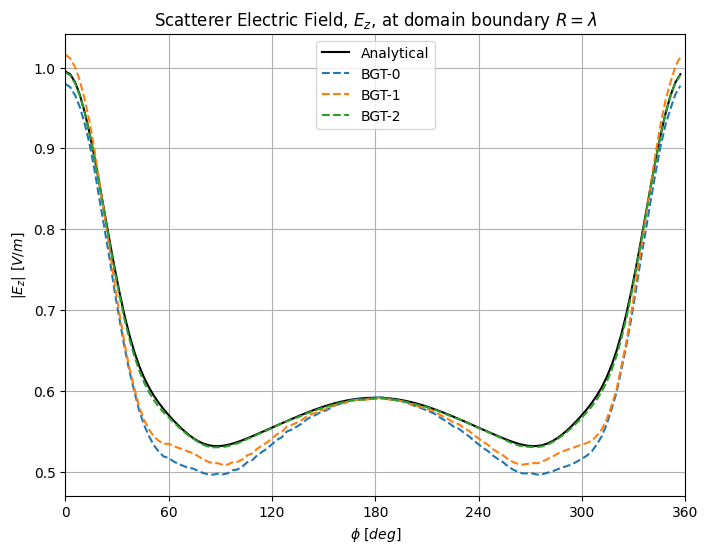

Processing domain with R3 = 1.25λ
Model circular_pec (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 3650 nodes in total
Info     : 7017 2-D elements in total


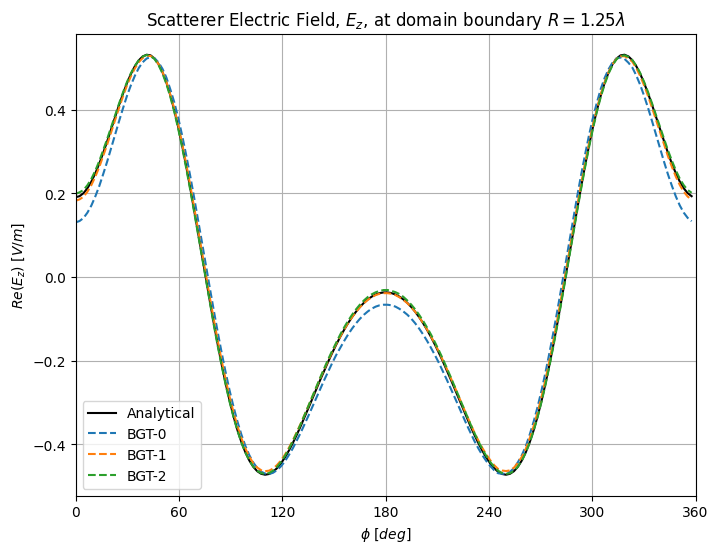

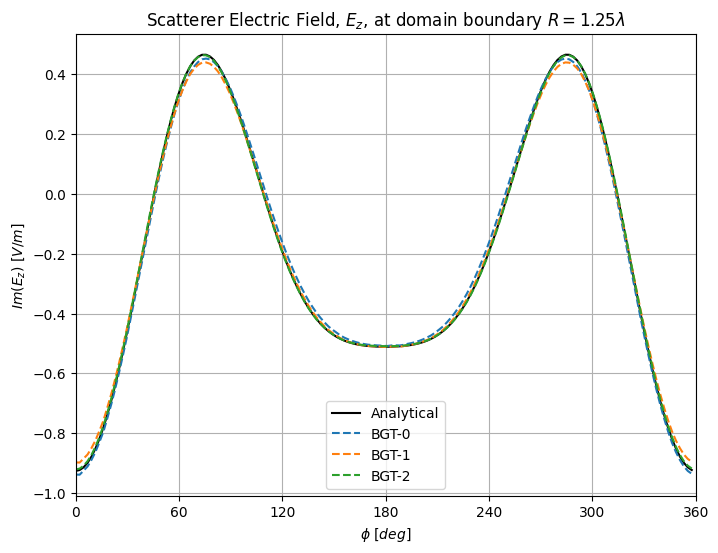

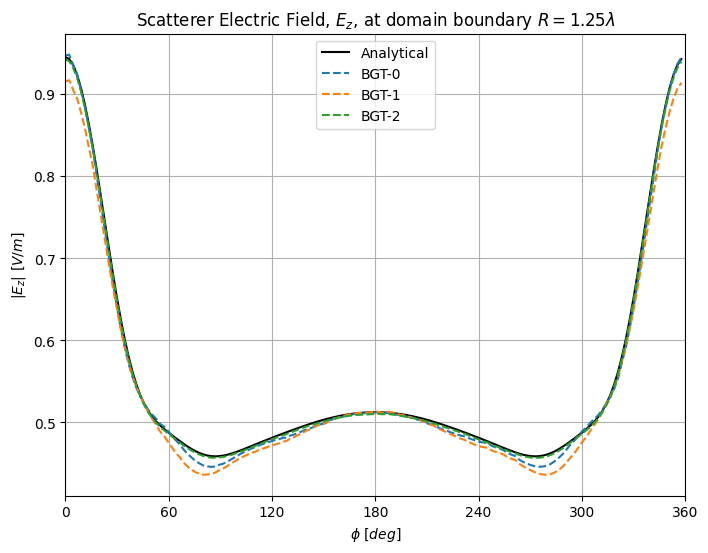

Processing domain with R4 = 1.5λ
Model circular_pec (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 5294 nodes in total
Info     : 10273 2-D elements in total


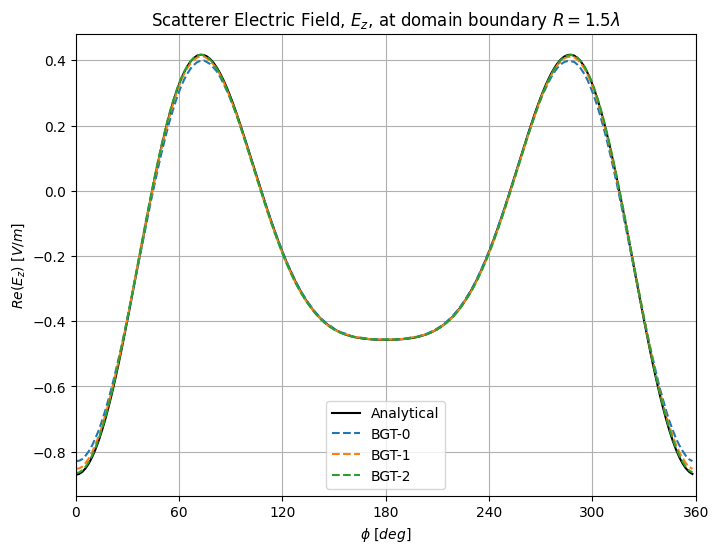

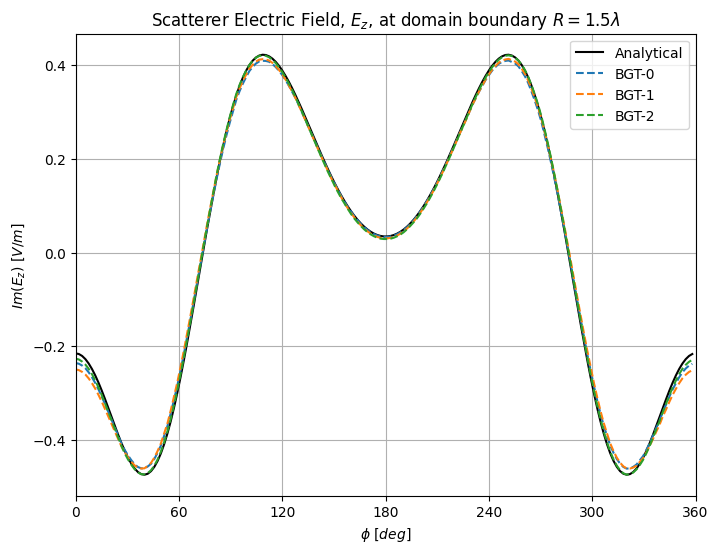

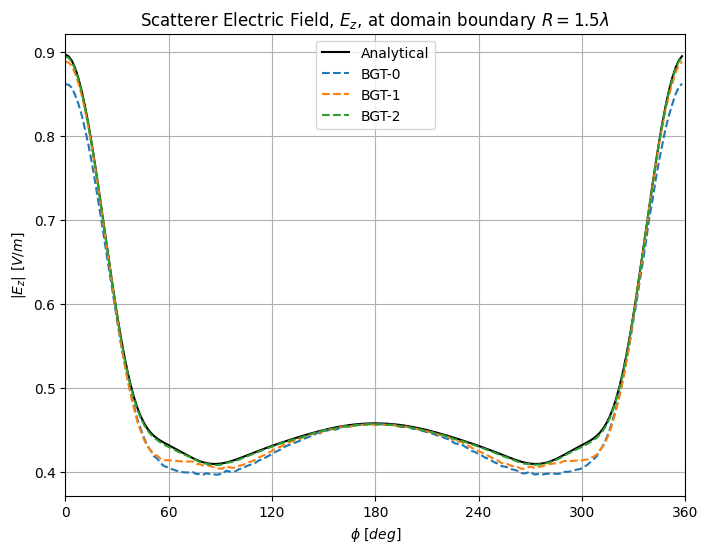

In [3]:
R_DOMAIN = {'R1': '0.75', 'R2': '', 'R3': '1.25', 'R4': '1.5'}
BGT = ['0', '1', '2']
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
error_dict = {}
ez_results_dict = {}

for R, R_value in R_DOMAIN.items():
    # Criação do domínio finito
    print(f"Processing domain with {R} = {R_value}λ")
    mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1/20, R=R, auto_save=False, view_mesh=False)
    
    # Montagem das matrizes globais
    Sgr, fgr, Mgr, Pgr, Qgr = ma.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
    
    # Aplicação das condições de contorno
    bgt_data = ps.apply_bgt_constants(R)
    
    # Solução analítica
    ez = ps.ez_at_omega(mesh_data)
    ez_exact = np.array(list(ez.values()))
    ez_results_dict['ez'] = ps.ez_at_contour(mesh_data, contour='BGT')

    # Inicialização do dicionário de erros    
    error_dict[R] = {}

    # Iteração sobre as condições de contorno
    for bgt in BGT:
        # Montagem da matriz global
        Agr = Sgr - (K0**2) *  Mgr + bgt_data[bgt]['ALPHA'] * Pgr - bgt_data[bgt]['BETA'] * Qgr

        # Solução do sistema linear
        ur = spsolve(Agr.tocsr(), fgr.toarray())
        ez_h = ma.global_potentials_solution(mesh_data, ur)

        # Nós do BGT
        bgt_nodes = {key: value 
            for key, value in mesh_data['nodes'].items() if value['bc']['type'] == 'BGT'}

        # Atualização do dicionário de resultados
        ez_results_dict[f'BGT-{bgt}'] = {key: ez_h[key] for key in bgt_nodes.keys()}

        # Cálculo do erro
        ez_approx = np.array(list(ez_h.values()))
        error = ps.calculate_error(ez_exact, ez_approx)
        error_dict[R][f'BGT-{bgt}'] = error

    ps.plot_ez_multi_profile(ez_results_dict, r_domain=R_value)
    

# Error Table

In [4]:
df_error = pd.DataFrame.from_dict({region: pd.Series(errors) for region, errors in error_dict.items()})
print(df_error)

             R1        R2        R3        R4
BGT-0  0.019512  0.029028  0.024553  0.020370
BGT-1  0.031330  0.030288  0.019713  0.014308
BGT-2  0.004853  0.002385  0.001480  0.001882


Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.